# Final Project: Credit Card Default Prediction 
Author: Tobby Yang, Ivy Chen, Jackson Fang

## Data Preprocessing

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
data = pd.read_csv('lending_club_loan_two.csv')

In [18]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


#### Check emp_title variable

In [19]:
data.emp_title.nunique()

173105

Since there are too many job titles, we need to drop it to avoid too many binary variables.

In [20]:
data.drop('emp_title', axis=1, inplace=True)

#### Check emp_length

In [21]:
# Check unique values
print(data['emp_length'].value_counts(dropna=False))


emp_length
10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
NaN           18301
9 years       15314
Name: count, dtype: int64


In [22]:
# Clean and convert emp_length to ordered categorical type
emp_order = ['< 1 year', '2 years', '3 years', '4 years', '5 years',
             '6 years', '7 years', '8 years', '9 years', '10+ years']

data['emp_length'] = pd.Categorical(data['emp_length'], categories=emp_order, ordered=True)


In [23]:
print(data['loan_status'].value_counts())


loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64


In [24]:
# Example: Define "Good" as fully paid or current
good_status = ['Fully Paid']
data['loan_status_binary'] = data['loan_status'].apply(lambda x: 0 if x in good_status else 1)
data.drop('loan_status', axis=1, inplace=True)


In [25]:
# Crosstab
pd.crosstab(data['emp_length'], data['loan_status_binary'], normalize='index') * 100


loan_status_binary,0,1
emp_length,,
< 1 year,79.312845,20.687155
2 years,80.673794,19.326206
3 years,80.476867,19.523133
4 years,80.761523,19.238477
5 years,80.781279,19.218721
6 years,81.080562,18.919438
7 years,80.522600,19.477400
8 years,80.023998,19.976002
9 years,79.952984,20.047016


In [26]:
data.drop('emp_length', axis=1, inplace=True)

Since we see a very similar pattern in loan status across emp_length, it does not provide too much information so we just drop it

#### Check differnce between title and purpose

In [27]:
data.title.value_counts().head()

title
Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
Name: count, dtype: int64

In [28]:
data.purpose.value_counts().head()

purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: count, dtype: int64

Since no huge difference, we drop title and keep the purpose

In [29]:
data.drop('title', axis=1, inplace=True)

#### Check mort_acc (number of mortgage account) missing values and refill with mean

In [30]:
data.mort_acc.value_counts().head()

mort_acc
0.0    139777
1.0     60416
2.0     49948
3.0     38049
4.0     27887
Name: count, dtype: int64

In [31]:
data.mort_acc.isna().sum()

37795

In [32]:
# Check correlation
data[['mort_acc', 'total_acc']].corr()


,mort_acc,total_acc
mort_acc,1.000000,0.381072
total_acc,0.381072,1.000000


Since total_acc (The total number of credit lines currently in the borrower's credit file) has a good correlation with mort_acc, we use this variable to help filling the missing value in mort_acc

In [33]:
mort_acc_fill = data.groupby('total_acc')['mort_acc'].mean()

def fill_mort_acc(row):
    if pd.isnull(row['mort_acc']):
        return mort_acc_fill.loc[row['total_acc']]
    else:
        return row['mort_acc']

data['mort_acc'] = data.apply(fill_mort_acc, axis=1)


In [34]:
data.mort_acc.isna().sum()

0

#### Check revol_util & pub_rec_bankruptcies

In [35]:
# Number of missing values
print("Missing revol_util:", data['revol_util'].isna().sum())
print("Missing pub_rec_bankruptcies:", data['pub_rec_bankruptcies'].isna().sum())

# % of missing values
print("Missing revol_util (%):", data['revol_util'].isna().mean())
print("Missing pub_rec_bankruptcies (%):", data['pub_rec_bankruptcies'].isna().mean())


Missing revol_util: 276
Missing pub_rec_bankruptcies: 535
Missing revol_util (%): 0.0006969169002348307
Missing pub_rec_bankruptcies (%): 0.0013509077595131682


For revol_util, it is a skewed distribution variable, so we fill with median. For pub_rec_bankruptcies, it is always 0 so we fill with mode

In [36]:
data['revol_util'] = data['revol_util'].fillna(data['revol_util'].median())
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].fillna(data['pub_rec_bankruptcies'].mode()[0])

#### Drop Other na's to ensure the model could function 

In [37]:
len(data)

396030

In [38]:
data.dropna(inplace=True)

In [39]:
len(data)

396030

#### Clean categorical variables and dummy variables

Clean 'term'

In [40]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

Clean 'grade & sub_grade', since grade is same as sub_grade, we just drop it

In [41]:
data.drop('grade', axis=1, inplace=True)

Make Categorical Variables into Dummies

In [42]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
# One-hot encode safely
data = pd.get_dummies(data, columns=dummies, drop_first=True)

Clean address

In [43]:
data.address.head()

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

we only want the zip code in the end

In [44]:
if 'address' in data.columns:
    data['zip_code'] = data['address'].apply(lambda x: x[-5:])
    data.drop('address', axis=1, inplace=True)

In [45]:
data.zip_code.value_counts()

zip_code
70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: count, dtype: int64

In [46]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

Drop issue_d because we don't want the model knows whether a loan is issued when evaluating

In [47]:
data = data.drop('issue_d', axis=1)

Clean earliest_cr_line, which is a time feature

In [48]:
# Convert earliest_cr_line to datetime first
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')

# Then extract the year

data['earliest_cr_line'] = data['earliest_cr_line'].dt.year

/var/folders/jl/3nlnr52d30g_q0vq1dn9n60r0000gn/T/ipykernel_22497/1335824360.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')


#### Check Cleaning Results

In [49]:
data.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,...,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.0,36,11.44,329.48,117000.0,26.24,1990,16.0,0.0,36369.0,...,True,False,False,True,False,False,False,False,False,False
1,8000.0,36,11.99,265.68,65000.0,22.05,2004,17.0,0.0,20131.0,...,False,True,False,False,False,False,False,False,False,False
2,15600.0,36,10.49,506.97,43057.0,12.79,2007,13.0,0.0,11987.0,...,True,True,False,False,False,False,False,False,False,False
3,7200.0,36,6.49,220.65,54000.0,2.60,2006,6.0,0.0,5472.0,...,True,False,False,False,False,False,False,False,False,False
4,24375.0,60,17.27,609.33,55000.0,33.95,1999,13.0,0.0,24584.0,...,False,False,True,False,False,False,False,False,False,False


In [50]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)


Columns with missing values:
 Series([], dtype: int64)


In [51]:
non_numeric = data.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:\n", non_numeric)


Non-numeric columns:
 Index([], dtype='object')


In [52]:
print(data['loan_status_binary'].value_counts())


loan_status_binary
0    318357
1     77673
Name: count, dtype: int64


In [53]:
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


## Random Forest Model

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split data (update the target variable name accordingly, e.g., 'loan_status' or similar)
X = data.drop('loan_status_binary', axis=1)  
y = data['loan_status_binary']               

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# Fit Random Forest model
rfc = RandomForestClassifier(n_estimators=500, random_state=666)
rfc.fit(X_train, y_train)

# Predict and evaluate
y_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[63415   201]
 [ 8605  6985]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     63616
           1       0.97      0.45      0.61     15590

    accuracy                           0.89     79206
   macro avg       0.93      0.72      0.77     79206
weighted avg       0.90      0.89      0.87     79206



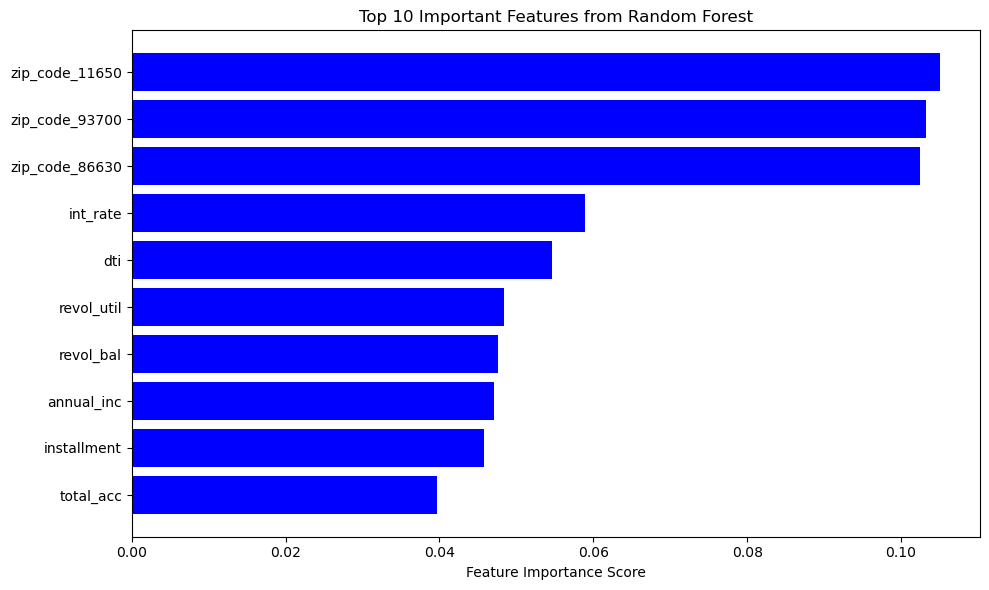

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances
importances = rfc.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:]  # Top 15 important features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names[indices], importances[indices], color='blue')
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Important Features from Random Forest")
plt.tight_layout()
plt.show()
